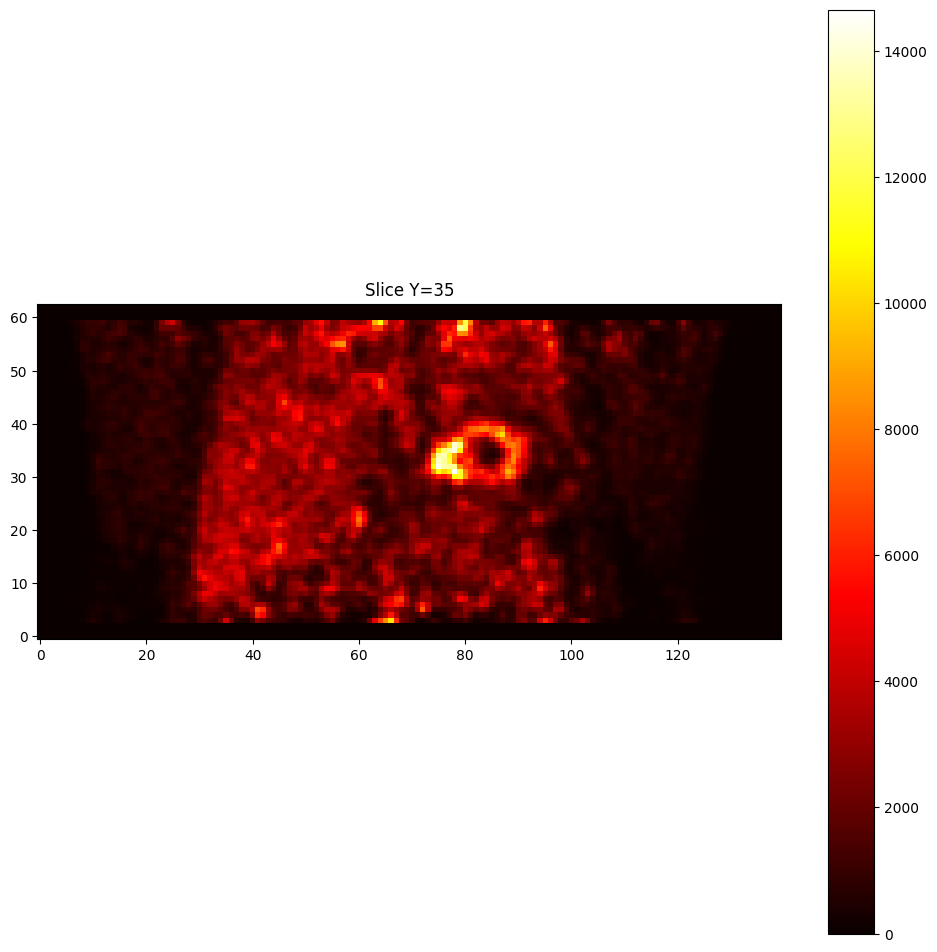

In [50]:
import numpy as np
import matplotlib.pyplot as plt


hdr_path = "/Users/yuema/MyCode/castor_v3.2/benchmark/benchmark_pet_list-mode_challenger_it2.hdr"
img_path = hdr_path.replace(".hdr", ".img")

# 1️⃣ read from the hearder
shape = []
voxel_size = []
byte_order = 'little'
dtype = None

with open(hdr_path, 'r') as f:
    for line in f:
        if "matrix size [1]" in line:
            shape.insert(0, int(line.split(":=")[-1]))
        elif "matrix size [2]" in line:
            shape.insert(0, int(line.split(":=")[-1]))
        elif "matrix size [3]" in line:
            shape.insert(0, int(line.split(":=")[-1]))
        elif "number format" in line:
            fmt = line.split(":=")[-1].strip().lower()
            if "short float" in fmt:
                dtype = np.float32
            elif "long float" in fmt:
                dtype = np.float64
            elif "signed integer" in fmt:
                dtype = np.int32
            elif "unsigned integer" in fmt:
                dtype = np.uint32
        elif "imagedata byte order" in line:
            if "little" in line.lower():
                byte_order = "little"
            elif "big" in line.lower():
                byte_order = "big"

# 2️⃣ read the binary data
byteorder_prefix = "<" if byte_order == "little" else ">"
with open(img_path, "rb") as f:
    data = np.fromfile(f, dtype=byteorder_prefix + dtype().dtype.char)

# 3️⃣ reshape to 3d array
data = data.reshape(shape)


fig = plt.figure(figsize=(12, 12))
y = shape[1] // 2
plt.imshow(data[:, y, :], cmap="hot", origin="lower")
plt.title(f"Slice Y={y}")
plt.colorbar()
plt.show()


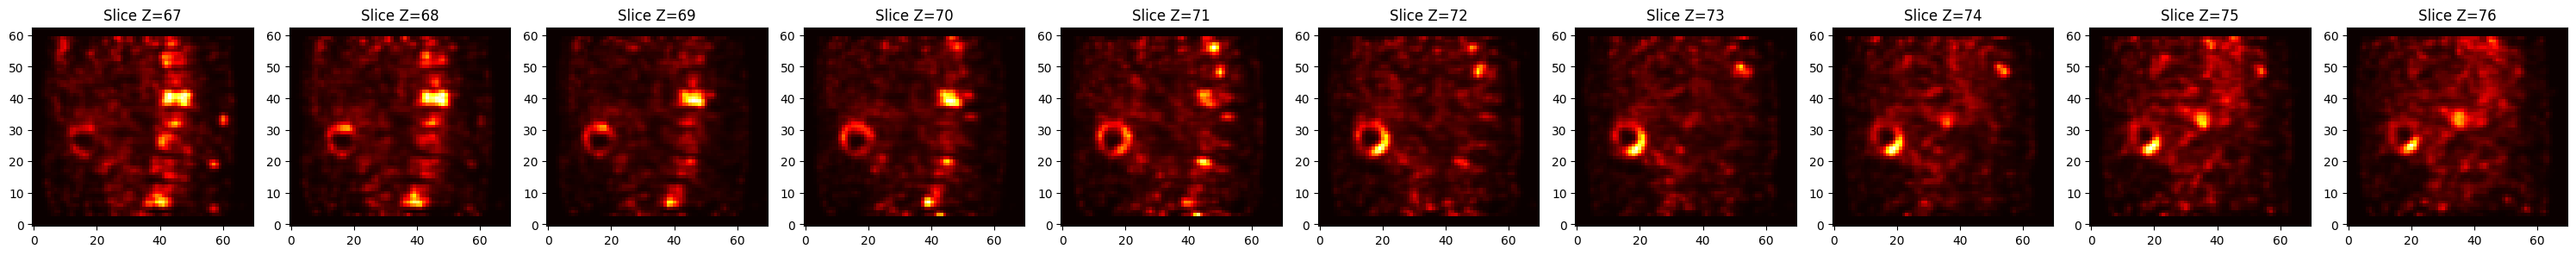

In [51]:
# plot z slices
fig, axes = plt.subplots(1, 10, figsize=(30, 10))
for i, ax in enumerate(axes):
    z = i + shape[2] // 2 - 3
    ax.imshow(data[:, :, z], cmap="hot", origin="lower")
    ax.set_title(f"Slice Z={z}")
    #plt.colorbar(ax.imshow(data[:, :, z], cmap="hot", origin="lower"), ax=ax)
plt.tight_layout()
plt.show()

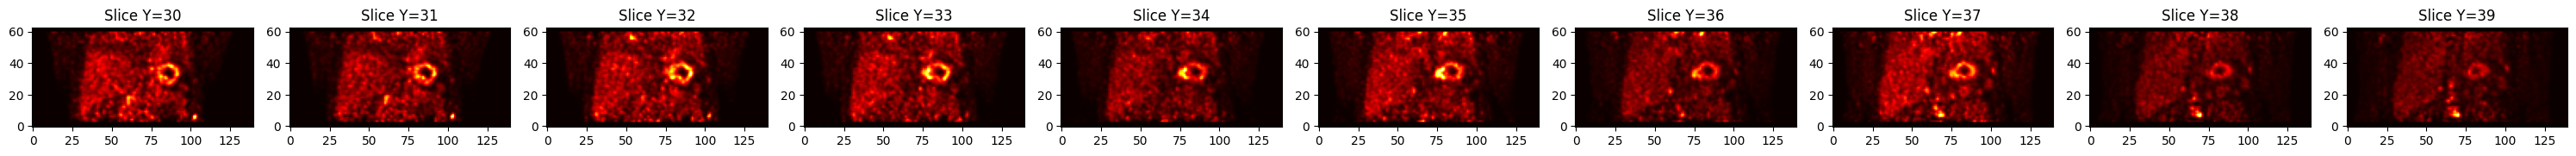

In [52]:
# plot y slices
fig, axes = plt.subplots(1, 10, figsize=(30, 10))
for i, ax in enumerate(axes):
    y = i + shape[1] // 2 - 5
    ax.imshow(data[:, y, :], cmap="hot", origin="lower")
    ax.set_title(f"Slice Y={y}")
    #plt.colorbar(ax.imshow(data[:, y, :], cmap="hot", origin="lower"), ax=ax)
plt.tight_layout()
plt.show()

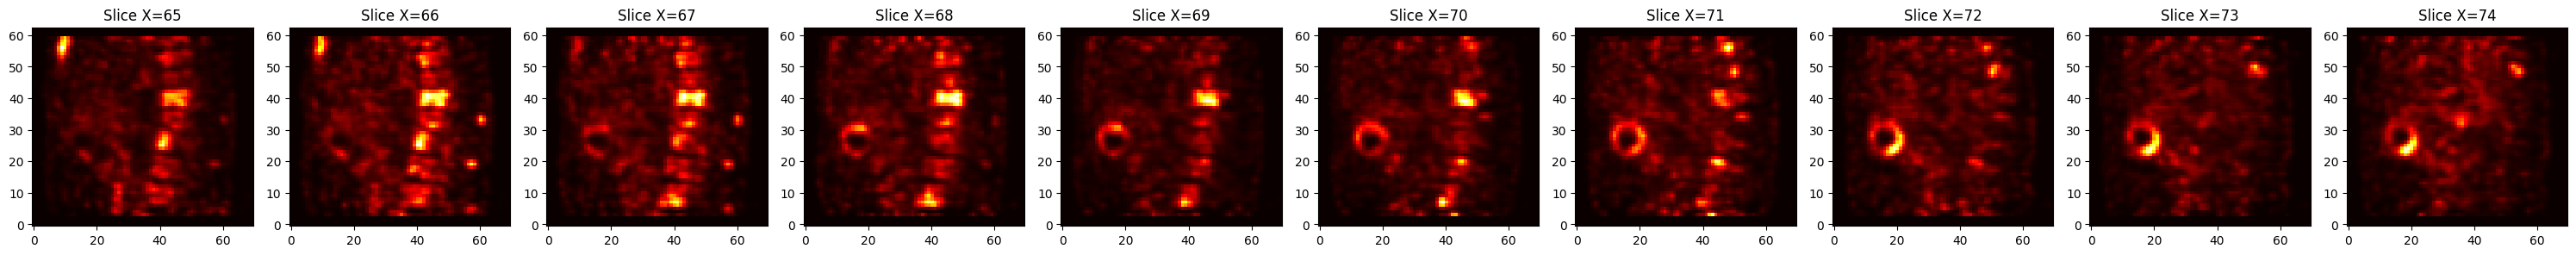

In [53]:
# plot x slices
fig, axes = plt.subplots(1, 10, figsize=(30, 10))
for i, ax in enumerate(axes):
    x = i + shape[2] // 2 - 5
    ax.imshow(data[:, :, x], cmap="hot", origin="lower")
    ax.set_title(f"Slice X={x}")
    #plt.colorbar(ax.imshow(data[:, y, :], cmap="hot", origin="lower"), ax=ax)
plt.tight_layout()
plt.show()

### Check configs and headers

In [54]:
raw_data_header = "/Users/yuema/MyCode/castor_v3.2/benchmark/benchmark_pet_list-mode_tof.cdh"
raw_data_file = "/Users/yuema/MyCode/castor_v3.2/benchmark/benchmark_pet_list-mode_tof.cdf"
config_header = "/Users/yuema/MyCode/castor_v3.2/config/scanner/PET_GE_SIGNA_PET-MR.hscan"
config_lut = "/Users/yuema/MyCode/castor_v3.2/config/scanner/PET_GE_SIGNA_PET-MR.lut"

#### Config lut

In [55]:
import numpy as np

def check_binary_lut(filepath, expected_elements=None):
    try:
        data = np.fromfile(filepath, dtype=np.float32)
        if len(data) % 6 != 0:
            raise ValueError("The binary .lut file does not contain a multiple of 6 floats per crystal.")
        num_crystals = len(data) // 6
        print(f"✅ Total crystals found: {num_crystals}")
        if expected_elements is not None and num_crystals != expected_elements:
            print(f"❌ Mismatch with expected number of elements: {expected_elements}")
        else:
            print("✅ Number of elements matches expectation.")

        # Check orientation vectors norm
        vectors = data.reshape((-1, 6))[:, 3:6]
        norms = np.linalg.norm(vectors, axis=1)
        if not np.allclose(norms, 1.0, atol=1e-2):
            print("⚠️ Warning: Some orientation vectors are not unit length (||v|| != 1).")
        else:
            print("✅ Orientation vectors look normalized.")
    except Exception as e:
        print(f"❌ Error reading binary LUT: {e}")


check_binary_lut(config_lut, expected_elements=20160)


✅ Total crystals found: 20160
✅ Number of elements matches expectation.
✅ Orientation vectors look normalized.


In [56]:
import numpy as np

def print_lut_preview(filepath, num_crystals=5):
    # read the whole file
    data = np.fromfile(filepath, dtype=np.float32)

    if len(data) % 6 != 0:
        raise ValueError("File length is not divisible by 6. Each crystal should have 6 float32 values.")

    data = data.reshape((-1, 6))
    print(f"Total crystals: {data.shape[0]}\n")
    print(f"Showing first {num_crystals} crystals:")

    for i in range(min(num_crystals, data.shape[0])):
        pos = data[i, 0:3]
        ori = data[i, 3:6]
        print(f"Crystal {i}:")
        print(f"  Position (x, y, z): {pos}")
        print(f"  Orientation (vx, vy, vz): {ori}")
        print()

# usage
print_lut_preview(config_lut, num_crystals=5)


Total crystals: 20160

Showing first 5 crystals:
Crystal 0:
  Position (x, y, z): [ -30.2625   329.5     -122.54222]
  Orientation (vx, vy, vz): [0. 1. 0.]

Crystal 1:
  Position (x, y, z): [ -26.2875   329.5     -122.54222]
  Orientation (vx, vy, vz): [0. 1. 0.]

Crystal 2:
  Position (x, y, z): [ -22.3125   329.5     -122.54222]
  Orientation (vx, vy, vz): [0. 1. 0.]

Crystal 3:
  Position (x, y, z): [ -18.337502  329.5      -122.54222 ]
  Orientation (vx, vy, vz): [0. 1. 0.]

Crystal 4:
  Position (x, y, z): [ -14.062501  329.5      -122.54222 ]
  Orientation (vx, vy, vz): [0. 1. 0.]



#### Raw data file

In [57]:
import struct 

def parse_cdh_for_event_structure(cdh_path):
    with open(cdh_path, "r") as f:
        lines = f.readlines()

    fields = [("time", "I")]  # uint32
    total_size = 4

    # Flags from the header
    flags = {line.split(":")[0].strip(): line.split(":")[1].strip() for line in lines if ":" in line}
    
    def add_field(name, fmt, size):
        fields.append((name, fmt))
        return size

    if flags.get("Attenuation correction flag", "0") == "1":
        total_size += add_field("attenuation", "f", 4)
    if flags.get("Scatter correction flag", "0") == "1":
        total_size += add_field("scatter", "f", 4)
    if flags.get("Random correction flag", "0") == "1":
        total_size += add_field("random", "f", 4)
    if flags.get("Normalization correction flag", "0") == "1":
        total_size += add_field("normalization", "f", 4)
    if flags.get("TOF information flag", "0") == "1":
        total_size += add_field("tof", "f", 4)
        if flags.get("Per event TOF resolution flag", "0") == "1":
            total_size += add_field("tof_resolution", "f", 4)

    # Always present: 2 crystal IDs
    total_size += add_field("crystal1", "I", 4)
    total_size += add_field("crystal2", "I", 4)

    format_string = "<" + "".join(fmt for _, fmt in fields)

    return fields, format_string, total_size

def read_castor_event_auto(file, i, format_string, event_size):
    file.seek(i * event_size)
    data = file.read(event_size)
    if len(data) < event_size:
        return None
    values = struct.unpack(format_string, data)
    return values

def preview_castor_cdf_auto(cdf_path, cdh_path, num_events=5):
    fields, fmt, evt_size = parse_cdh_for_event_structure(cdh_path)
    print(f"Detected structure: {fields}")
    print(f"Total event size: {evt_size} bytes")

    with open(cdf_path, "rb") as f:
        for i in range(num_events):
            result = read_castor_event_auto(f, i, fmt, evt_size)
            if result is None:
                break
            print(f"Event {i}:")
            for (name, _), val in zip(fields, result):
                print(f"  {name}: {val}")
            print()

# usage
preview_castor_cdf_auto(raw_data_file, raw_data_header, num_events=5)



Detected structure: [('time', 'I'), ('attenuation', 'f'), ('scatter', 'f'), ('random', 'f'), ('normalization', 'f'), ('tof', 'f'), ('crystal1', 'I'), ('crystal2', 'I')]
Total event size: 32 bytes
Event 0:
  time: 830956
  attenuation: 24.09225082397461
  scatter: 2.1628741819768038e-07
  random: 0.00010076240141643211
  normalization: 1.2539879083633423
  tof: -624.9600219726562
  crystal1: 631
  crystal2: 7108

Event 1:
  time: 830956
  attenuation: 16.687414169311523
  scatter: 2.2032646995739924e-07
  random: 0.00011687124788295478
  normalization: 1.1026785373687744
  tof: -807.2400512695312
  crystal1: 14939
  crystal2: 7140

Event 2:
  time: 830956
  attenuation: 12.581854820251465
  scatter: 5.714462645300955e-07
  random: 0.00011404224642319605
  normalization: 1.3658506870269775
  tof: -117.18000793457031
  crystal1: 1808
  crystal2: 7435

Event 3:
  time: 830956
  attenuation: 13.115365982055664
  scatter: 4.117372895962035e-07
  random: 0.00011505995644256473
  normalization

### Pseudo data with new configs

In [58]:
new_config_path =  "/Users/yuema/MyCode/LXePETSim/LXePETSim/castor_reconstruction/castor_configs"
new_data_path = "/Users/yuema/MyCode/LXePETSim/LXePETSim/castor_reconstruction/castor_data"

new_config_lut = "{}/philips_vereos_virtual_crystals_binary.lut".format(new_config_path)
new_config_header = "{}/philips_vereos_virtual_crystals.hscan".format(new_config_path)
# test the lut file that we generated
print_lut_preview(new_config_lut, num_crystals=5)

Total crystals: 23040

Showing first 5 crystals:
Crystal 0:
  Position (x, y, z): [-385.55225  -67.98326  -78.5    ]
  Orientation (vx, vy, vz): [0.9848077  0.17364818 0.        ]

Crystal 1:
  Position (x, y, z): [-384.78772  -72.18485  -78.5    ]
  Orientation (vx, vy, vz): [0.98285496 0.18438022 0.        ]

Crystal 2:
  Position (x, y, z): [-383.97745  -76.37786  -78.5    ]
  Orientation (vx, vy, vz): [0.98078525 0.19509032 0.        ]

Crystal 3:
  Position (x, y, z): [-383.12146   -80.561775  -78.5     ]
  Orientation (vx, vy, vz): [0.9785989  0.20577721 0.        ]

Crystal 4:
  Position (x, y, z): [-382.21988  -84.73611  -78.5    ]
  Orientation (vx, vy, vz): [0.976296   0.21643962 0.        ]



In [59]:
import struct
import numpy as np
import pandas as pd

def write_simple_binary_cdf(
    output_path,
    num_events,
    n_crystals,
    start_time=0
):
    with open(output_path, "wb") as f:
        for i in range(num_events):
            t = start_time + i  # fake time
            c1 = np.random.randint(0, n_crystals)
            c2 = np.random.randint(0, n_crystals)
            data = struct.pack("<III", t, c1, c2)
            f.write(data)
    print(f"[CDF] Wrote {num_events} events to: {output_path}")


coincidence_file = "/Users/yuema/MyCode/LXePETSim/LXePETSim/PET_example/output/coincidences.csv"
lut_df = data = np.fromfile(new_config_lut, dtype=np.float32)

In [60]:
lut_df = lut_df.reshape((-1, 6))

In [61]:
# assign column names, index is crystal_id
lut_df = pd.DataFrame(lut_df, columns=["x", "y", "z", "vx", "vy", "vz"])
# add a column for crystal_id
lut_df.index.name = "crystal_id"
lut_df.reset_index(inplace=True)

In [62]:
len(lut_df)

23040

In [63]:
from scipy.spatial import cKDTree

coinc_data = pd.read_csv(coincidence_file)

# Build KDTree for quick nearest-neighbor lookup
crystal_pos = lut_df[["x", "y", "z"]].values
tree = cKDTree(crystal_pos)

# Positions of gamma hits (from simulation)
positions1 = np.vstack([coinc_data["globalPosX1"], coinc_data["globalPosY1"], coinc_data["globalPosZ1"]]).T
positions2 = np.vstack([coinc_data["globalPosX2"], coinc_data["globalPosY2"], coinc_data["globalPosZ2"]]).T

# Find nearest crystal index
_, idx1 = tree.query(positions1)
_, idx2 = tree.query(positions2)


In [64]:
def write_castor_cdf_from_crystal_ids(path, t0, crystal1_ids, crystal2_ids):
    with open(path, "wb") as f:
        for i, (c1, c2) in enumerate(zip(crystal1_ids, crystal2_ids)):
            t = t0 + i  # fake time increasing
            data = struct.pack("<III", t, c1, c2)
            f.write(data)
    print(f"[CDF] {len(crystal1_ids)} events written to {path}")
    
write_castor_cdf_from_crystal_ids("/Users/yuema/MyCode/castor_v3.2/LXePET/philips_vereos_sim.cdf", t0=0, crystal1_ids=idx1, crystal2_ids=idx2)

[CDF] 11412 events written to /Users/yuema/MyCode/castor_v3.2/LXePET/philips_vereos_sim.cdf


In [65]:
def write_simple_text_cdh(output_path, data_file_name, num_events):
    with open(output_path, "w") as f:
        f.write(f"Data filename: {data_file_name}\n")
        f.write(f"Number of events: {num_events}\n")
        f.write("Data mode: list-mode\n")
        f.write("Data type: PET\n")
        f.write("Start time (s): 0\n")
        f.write("Duration (s): 10\n")
        f.write("Scanner name: PET_PHILIPS_VEREOS\n")
        f.write("Calibration factor: 1.0\n")
        f.write("Isotope: F-18\n")
        f.write("TOF information flag: 0\n")
        f.write("Attenuation correction flag: 0\n")
        f.write("Normalization correction flag: 0\n")
        f.write("Scatter correction flag: 0\n")
        f.write("Random correction flag: 0\n")
        f.write("Maximum number of lines per event: 1\n")
    print(f"[CDH] Wrote header to: {output_path}")


write_simple_text_cdh(f"/Users/yuema/MyCode/castor_v3.2/LXePET/philips_vereos_sim.cdh",
                      data_file_name="/Users/yuema/MyCode/castor_v3.2/LXePET/philips_vereos_sim.cdf",
                      num_events=len(coinc_data))

new_data_header = f"/Users/yuema/MyCode/castor_v3.2/LXePET/philips_vereos_sim.cdh"
new_data_file = f"/Users/yuema/MyCode/castor_v3.2/LXePET/philips_vereos_sim.cdf"

[CDH] Wrote header to: /Users/yuema/MyCode/castor_v3.2/LXePET/philips_vereos_sim.cdh


In [66]:
len(lut_df)

23040

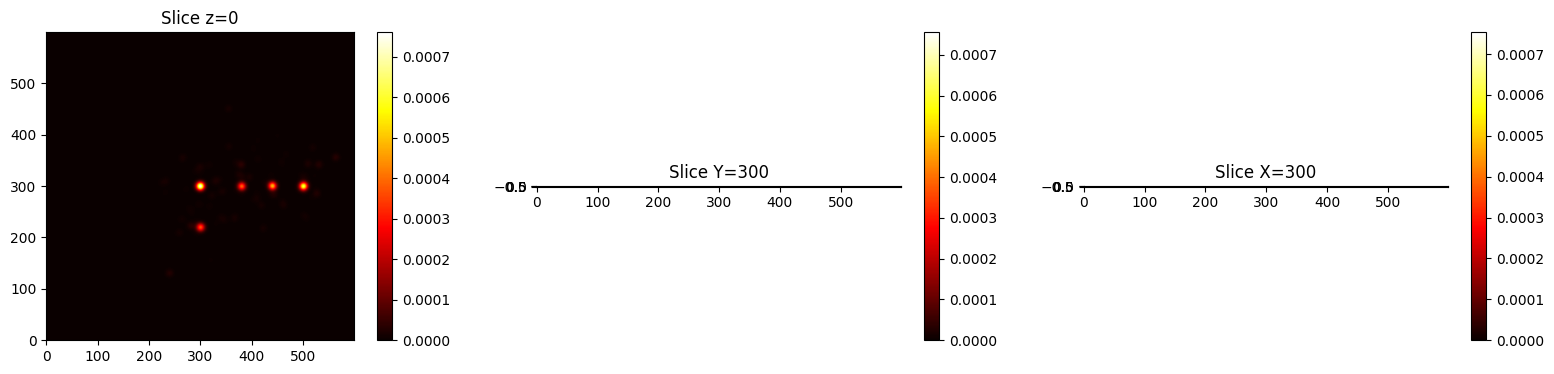

In [67]:

hdr_path = "/Users/yuema/MyCode/castor_v3.2/LXePET/philips_vereos_sim_data_it2.hdr"
img_path = hdr_path.replace(".hdr", ".img")

# 1️⃣ read from the hearder
shape = []
voxel_size = []
byte_order = 'little'
dtype = None

with open(hdr_path, 'r') as f:
    for line in f:
        if "matrix size [1]" in line:
            shape.insert(0, int(line.split(":=")[-1]))
        elif "matrix size [2]" in line:
            shape.insert(0, int(line.split(":=")[-1]))
        elif "matrix size [3]" in line:
            shape.insert(0, int(line.split(":=")[-1]))
        elif "number format" in line:
            fmt = line.split(":=")[-1].strip().lower()
            if "short float" in fmt:
                dtype = np.float32
            elif "long float" in fmt:
                dtype = np.float64
            elif "signed integer" in fmt:
                dtype = np.int32
            elif "unsigned integer" in fmt:
                dtype = np.uint32
        elif "imagedata byte order" in line:
            if "little" in line.lower():
                byte_order = "little"
            elif "big" in line.lower():
                byte_order = "big"

# 2️⃣ read the binary data
byteorder_prefix = "<" if byte_order == "little" else ">"
with open(img_path, "rb") as f:
    data = np.fromfile(f, dtype=byteorder_prefix + dtype().dtype.char)

# 3️⃣ reshape to 3d array
data = data.reshape(shape)


fig, ax = plt.subplots(1,3,figsize=(20, 4))

z = shape[0] // 2
ax[0].imshow(data[z, :, :], cmap="hot", origin="lower")
ax[0].set_title(f"Slice z={z}")
fig.colorbar(ax[0].images[0], ax=ax[0])

y = shape[1] // 2
ax[1].imshow(data[:, y, :], cmap="hot", origin="lower")
ax[1].set_title(f"Slice Y={y}")
fig.colorbar(ax[1].images[0], ax=ax[1])

x = shape[2] // 2
ax[2].imshow(data[:, :, x], cmap="hot", origin="lower")
ax[2].set_title(f"Slice X={x}")
fig.colorbar(ax[2].images[0], ax=ax[2])
plt.show()


In [68]:
print(f"Image shape: {shape}")

Image shape: [1, 600, 600]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.ndimage import maximum_filter

# Define 2D Gaussian function
def gaussian_2d(xy, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    """
    2D Gaussian function
    xy: (x, y) coordinate grid
    amplitude: peak amplitude
    x0, y0: center position
    sigma_x, sigma_y: standard deviation in x and y directions
    theta: rotation angle
    offset: background offset
    """
    x, y = xy
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    
    return offset + amplitude * np.exp(-(a*(x-x0)**2 + 2*b*(x-x0)*(y-y0) + c*(y-y0)**2))

def find_peaks_simple(data, min_distance=10, threshold_rel=0.1):
    """
    Simple peak detection using maximum filter
    """
    # Apply maximum filter to find local maxima
    local_maxima = maximum_filter(data, size=min_distance) == data
    
    # Apply threshold
    threshold = threshold_rel * np.max(data)
    peaks_mask = local_maxima & (data > threshold)
    
    # Get peak coordinates
    peak_coords = np.where(peaks_mask)
    peaks = list(zip(peak_coords[0], peak_coords[1]))
    
    return peaks

def extract_roi(data, center, size=20):
    """
    Extract ROI region centered at given position
    """
    y, x = center
    half_size = size // 2
    
    y_min = max(0, y - half_size)
    y_max = min(data.shape[0], y + half_size)
    x_min = max(0, x - half_size)
    x_max = min(data.shape[1], x + half_size)
    
    roi = data[y_min:y_max, x_min:x_max]
    return roi, (y_min, x_min)

def fit_gaussian_peak(data, peak_pos, roi_size=20):
    """
    Fit 2D Gaussian to a single peak
    """
    # Extract ROI
    roi, (y_offset, x_offset) = extract_roi(data, peak_pos, roi_size)
    
    # Create coordinate grids - flatten them for curve_fit
    y_roi, x_roi = np.mgrid[0:roi.shape[0], 0:roi.shape[1]]
    x_roi_flat = x_roi.ravel()
    y_roi_flat = y_roi.ravel()
    
    # Initial parameter estimates
    amplitude_init = np.max(roi) - np.min(roi)
    x0_init = peak_pos[1] - x_offset
    y0_init = peak_pos[0] - y_offset
    sigma_init = 2.0
    theta_init = 0.0
    offset_init = np.min(roi)
    
    initial_guess = [amplitude_init, x0_init, y0_init, sigma_init, sigma_init, theta_init, offset_init]
    
    # Set parameter bounds
    bounds_lower = [0, 0, 0, 0.5, 0.5, -np.pi, 0]
    bounds_upper = [np.inf, roi.shape[1]-1, roi.shape[0]-1, roi.shape[1], roi.shape[0], np.pi, np.inf]
    
    try:
        # Perform fitting with flattened coordinates
        popt, pcov = curve_fit(
            gaussian_2d, 
            (x_roi_flat, y_roi_flat), 
            roi.ravel(),
            p0=initial_guess,
            bounds=(bounds_lower, bounds_upper),
            maxfev=5000
        )
        
        # Calculate goodness of fit
        fitted = gaussian_2d((x_roi_flat, y_roi_flat), *popt).reshape(roi.shape)
        r_squared = 1 - np.sum((roi - fitted)**2) / np.sum((roi - np.mean(roi))**2)
        
        return popt, pcov, r_squared, roi, fitted
    
    except Exception as e:
        print(f"Fitting failed: {e}")
        return None, None, None, roi, None

def calculate_fwhm(sigma_x, sigma_y):
    """
    Calculate FWHM from Gaussian standard deviation
    FWHM = 2 * sqrt(2 * ln(2)) * sigma ≈ 2.355 * sigma
    """
    fwhm_factor = 2 * np.sqrt(2 * np.log(2))
    fwhm_x = fwhm_factor * sigma_x
    fwhm_y = fwhm_factor * sigma_y
    fwhm_avg = np.sqrt(fwhm_x * fwhm_y)  # geometric mean
    return fwhm_x, fwhm_y, fwhm_avg

def analyze_peaks(data, min_distance=15, threshold_rel=0.1, roi_size=20):
    """
    Analyze all peaks in 2D data
    """
    # Find peak positions
    peaks = find_peaks_simple(data, min_distance=min_distance, threshold_rel=threshold_rel)
    print(f"Found {len(peaks)} peaks")
    
    if len(peaks) == 0:
        print("No peaks found. Try adjusting threshold_rel or min_distance parameters.")
        return []
    
    results = []
    
    # Create figure to display results
    n_peaks = len(peaks)
    fig, axes = plt.subplots(2, n_peaks, figsize=(4*n_peaks, 8))
    if n_peaks == 1:
        axes = axes.reshape(2, 1)
    
    for i, peak in enumerate(peaks):
        print(f"\nAnalyzing peak {i+1} at position {peak}")
        
        # Fit Gaussian
        fit_result = fit_gaussian_peak(data, peak, roi_size=roi_size)
        popt, pcov, r_squared, roi, fitted = fit_result
        
        if popt is not None:
            amplitude, x0, y0, sigma_x, sigma_y, theta, offset = popt
            
            # Calculate FWHM
            fwhm_x, fwhm_y, fwhm_avg = calculate_fwhm(abs(sigma_x), abs(sigma_y))
            
            # Calculate parameter uncertainties
            if pcov is not None:
                param_errors = np.sqrt(np.diag(pcov))
                sigma_x_err, sigma_y_err = abs(param_errors[3]), abs(param_errors[4])
                fwhm_x_err = 2.355 * sigma_x_err
                fwhm_y_err = 2.355 * sigma_y_err
            else:
                fwhm_x_err = fwhm_y_err = np.nan
            
            results.append({
                'peak_id': i+1,
                'position': peak,
                'amplitude': amplitude,
                'center': (x0, y0),
                'sigma_x': abs(sigma_x),
                'sigma_y': abs(sigma_y),
                'theta': theta,
                'offset': offset,
                'fwhm_x': fwhm_x,
                'fwhm_y': fwhm_y,
                'fwhm_avg': fwhm_avg,
                'fwhm_x_err': fwhm_x_err,
                'fwhm_y_err': fwhm_y_err,
                'r_squared': r_squared
            })
            
            print(f"  Amplitude: {amplitude:.2f}")
            print(f"  FWHM_x: {fwhm_x:.2f} ± {fwhm_x_err:.2f} pixels")
            print(f"  FWHM_y: {fwhm_y:.2f} ± {fwhm_y_err:.2f} pixels")
            print(f"  Average FWHM: {fwhm_avg:.2f} pixels")
            print(f"  R²: {r_squared:.4f}")
            
            # Plot original ROI
            axes[0, i].imshow(roi, cmap='hot', origin='lower')
            axes[0, i].set_title(f'Peak {i+1} - Original')
            axes[0, i].plot(x0, y0, 'w+', markersize=10, markeredgewidth=2)
            
            # Plot fitted ROI
            if fitted is not None:
                axes[1, i].imshow(fitted, cmap='hot', origin='lower')
                axes[1, i].set_title(f'Peak {i+1} - Fitted (R²={r_squared:.3f})')
                axes[1, i].plot(x0, y0, 'w+', markersize=10, markeredgewidth=2)
        else:
            print(f"  Fitting failed for peak {i+1}")
            axes[0, i].imshow(roi, cmap='hot', origin='lower')
            axes[0, i].set_title(f'Peak {i+1} - Original (Fit Failed)')
            axes[1, i].text(0.5, 0.5, 'Fit Failed', ha='center', va='center', 
                          transform=axes[1, i].transAxes, fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    return results

def main_analysis(data_3d, z_slice=None, **kwargs):
    """
    Main function to analyze peaks in your 3D data
    """
    if z_slice is None:
        z_slice = data_3d.shape[0] // 2
    
    # Extract 2D slice
    data_2d = data_3d[z_slice, :, :]
    
    # Display the original slice with detected peaks
    peaks = find_peaks_simple(data_2d, 
                             min_distance=kwargs.get('min_distance', 15),
                             threshold_rel=kwargs.get('threshold_rel', 0.1))
    
    plt.figure(figsize=(10, 8))
    plt.imshow(data_2d, cmap='hot', origin='lower')
    plt.title(f'Original slice z={z_slice} with detected peaks')
    plt.colorbar()
    
    # Mark detected peaks
    if peaks:
        peak_y, peak_x = zip(*peaks)
        plt.plot(peak_x, peak_y, 'w+', markersize=15, markeredgewidth=3)
        for i, (y, x) in enumerate(peaks):
            plt.text(x+2, y+2, f'{i+1}', color='white', fontsize=12, fontweight='bold')
    
    plt.show()
    
    # Analyze peaks
    results = analyze_peaks(data_2d, **kwargs)
    
    # Print summary
    if results:
        print(f"\n=== Summary for slice z={z_slice} ===")
        for result in results:
            print(f"Peak {result['peak_id']}: FWHM = {result['fwhm_avg']:.2f} pixels")
    
    return results


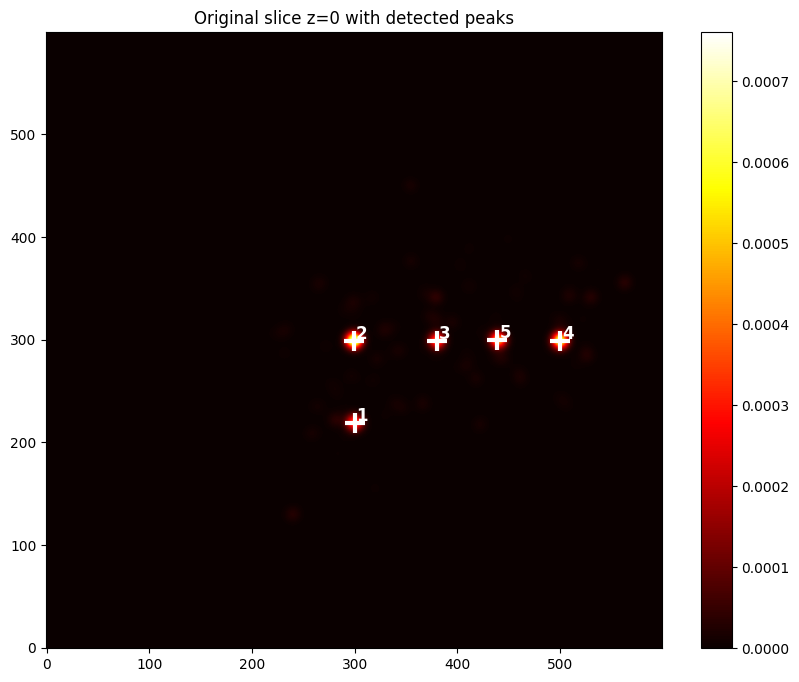

Found 5 peaks

Analyzing peak 1 at position (np.int64(219), np.int64(300))
  Amplitude: 0.00
  FWHM_x: 12.04 ± 0.04 pixels
  FWHM_y: 12.21 ± 0.04 pixels
  Average FWHM: 12.12 pixels
  R²: 0.9987

Analyzing peak 2 at position (np.int64(299), np.int64(299))
  Amplitude: 0.00
  FWHM_x: 12.57 ± 0.00 pixels
  FWHM_y: 12.61 ± 0.00 pixels
  Average FWHM: 12.59 pixels
  R²: 1.0000

Analyzing peak 3 at position (np.int64(299), np.int64(380))
  Amplitude: 0.00
  FWHM_x: 12.19 ± 0.02 pixels
  FWHM_y: 12.40 ± 0.02 pixels
  Average FWHM: 12.29 pixels
  R²: 0.9997

Analyzing peak 4 at position (np.int64(299), np.int64(500))
  Amplitude: 0.00
  FWHM_x: 12.57 ± 0.00 pixels
  FWHM_y: 12.83 ± 0.00 pixels
  Average FWHM: 12.70 pixels
  R²: 1.0000

Analyzing peak 5 at position (np.int64(300), np.int64(439))
  Amplitude: 0.00
  FWHM_x: 11.85 ± 0.03 pixels
  FWHM_y: 12.12 ± 0.03 pixels
  Average FWHM: 11.99 pixels
  R²: 0.9989


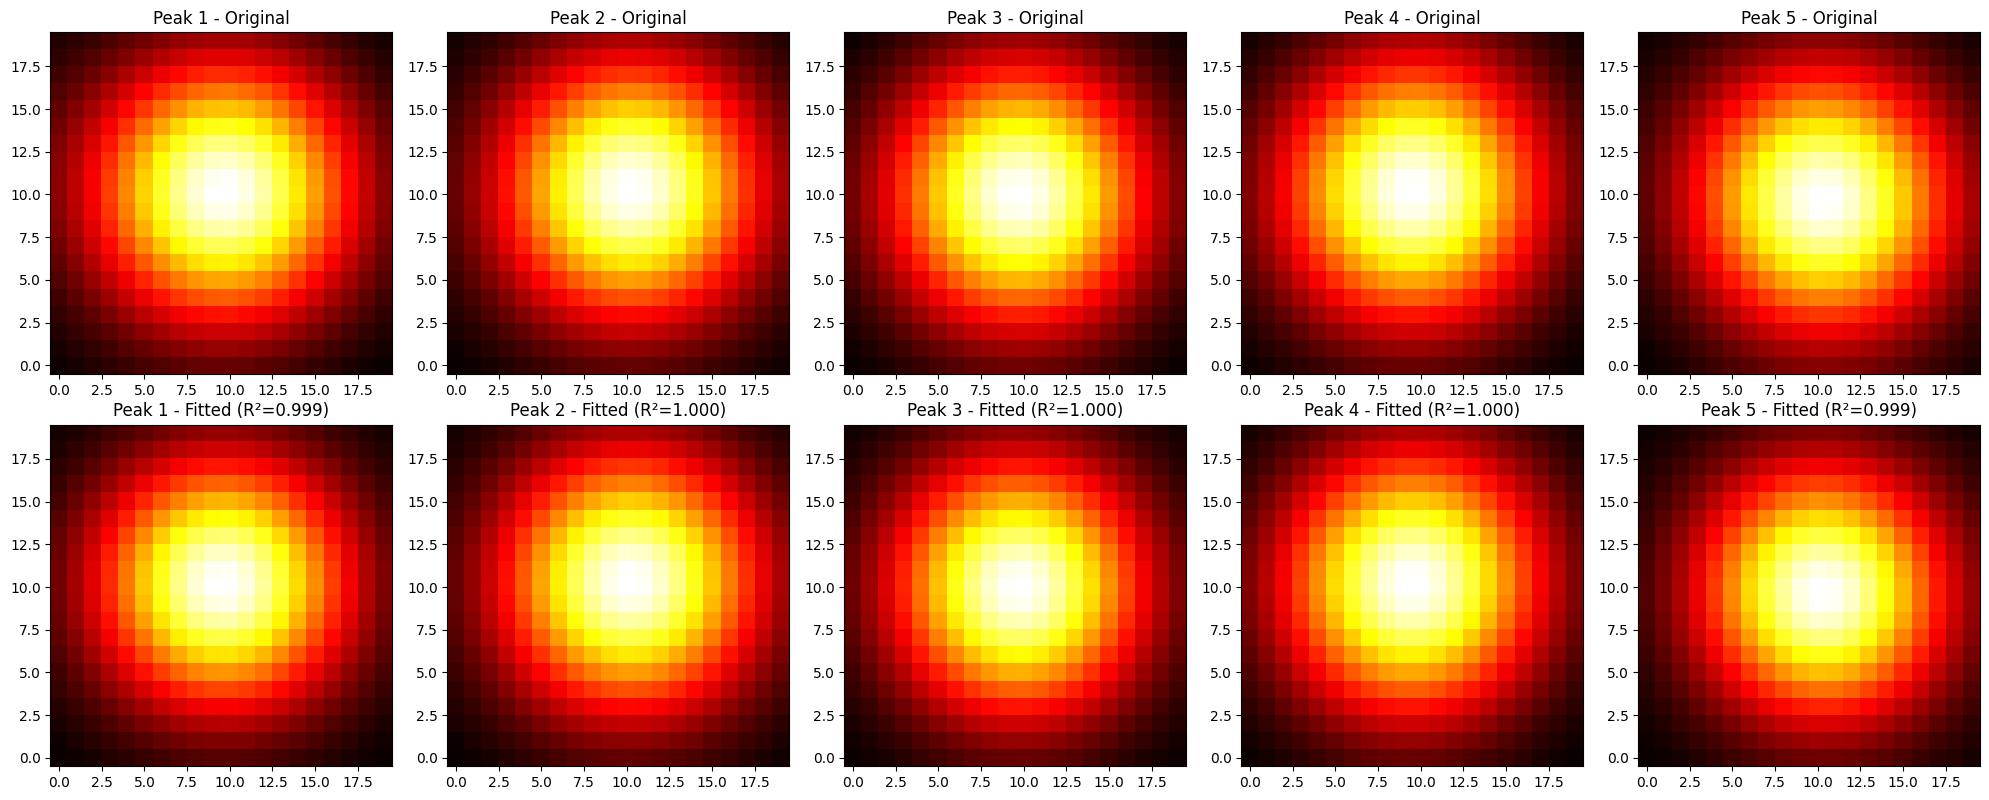


=== Summary for slice z=0 ===
Peak 1: FWHM = 12.12 pixels
Peak 2: FWHM = 12.59 pixels
Peak 3: FWHM = 12.29 pixels
Peak 4: FWHM = 12.70 pixels
Peak 5: FWHM = 11.99 pixels


In [70]:
# Usage example:
results = main_analysis(data, z_slice=shape[0]//2)
# 
# Optional parameters:
# results = main_analysis(data, z_slice=shape[0]//2, 
#                        min_distance=20,     # minimum distance between peaks
#                        threshold_rel=0.15,  # relative threshold for peak detection
#                        roi_size=30)         # ROI size for fitting